In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from itertools import count
import matplotlib
import gym
import gc
import time
from IPython.display import clear_output

In [2]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

## Deep-Q Network

In [9]:
class DQN(nn.Module):
    def __init__(self,
                 input_dim,
                 output_dim,
                 hidden_dims=(32, 32),
                 activation_fc=F.relu):
        super(DQN, self).__init__()
        self.activation_fc = activation_fc
        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims) - 1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i + 1])
            self.hidden_layers.append(hidden_layer)
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def _format(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x,
                             device=self.device,
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        return x

    def forward(self, state):
        x = self._format(state)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        x = self.output_layer(x)
        return x

    def load(self, experiences):
        states, actions, rewards, new_states, is_dones = experiences
        states = torch.tensor(states).float().to(self.device)
        actions = torch.tensor(actions).long().to(self.device)
        rewards = torch.tensor(rewards).float().to(self.device)
        new_states = torch.tensor(new_states).float().to(self.device)
        is_dones = torch.tensor(is_dones).float().to(self.device)
        return states, actions, rewards, new_states, is_dones


## Greedy Strategy to be used as evaluation

In [10]:
class GreedyStrategy():
    def __init__(self):
        self.exploratory_action_taken = False

    def select_action(self, model, state):
        with torch.no_grad():
            q_values = model(state).cpu().detach().data.numpy().squeeze()
            return np.argmax(q_values)


## Exponential Greedy Strategy

In [11]:
class EGreedyExpStrategy():
    def __init__(self, init_epsilon=1.0, min_epsilon=0.1, decay_steps=1000000):
        self.epsilon = init_epsilon
        self.init_epsilon = init_epsilon
        self.decay_steps = decay_steps
        self.min_epsilon = min_epsilon
        self.epsilons = 0.01 / np.logspace(-2, 0, decay_steps, endpoint=False) - 0.01
        self.epsilons = self.epsilons * (init_epsilon - min_epsilon) + min_epsilon
        self.t = 0
        self.exploratory_action_taken = None

    def _epsilon_update(self):
        self.epsilon = self.min_epsilon if self.t >= self.decay_steps else self.epsilons[self.t]
        self.t += 1
        return self.epsilon

    def select_action(self, model, state):
        self.exploratory_action_taken = False
        with torch.no_grad():
            q_values = model(state).detach().cpu().data.numpy().squeeze()

        if np.random.rand() > self.epsilon:
            action = np.argmax(q_values)
            self.exploratory_action_taken = False
        else:
            action = np.random.randint(len(q_values))
            self.exploratory_action_taken = True

        self._epsilon_update()
        return action


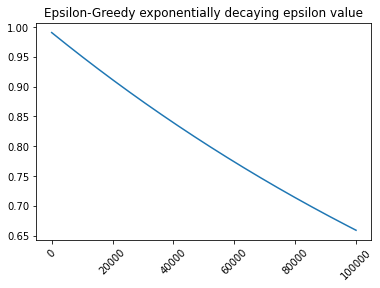

In [12]:
s = EGreedyExpStrategy()
plt.plot([s._epsilon_update() for _ in range(100000)])
plt.title('Epsilon-Greedy exponentially decaying epsilon value')
plt.xticks(rotation=45)
plt.show()

## Softmax Strategy

In [13]:
class SoftMaxStrategy():
    def __init__(self,
                 init_temp=1.0,
                 min_temp=0.1,
                 exploration_ratio=0.95,
                 max_steps=30000):
        self.t = 0
        self.init_temp = init_temp
        self.exploration_ratio = exploration_ratio
        self.min_temp = min_temp
        self.max_steps = max_steps
        self.exploratory_action_taken = None

    def _update_temp(self):
        temp = 1 - self.t / (self.max_steps * self.exploration_ratio)
        temp = (self.init_temp - self.min_temp) * temp + self.min_temp
        temp = np.clip(temp, self.min_temp, self.init_temp)
        self.t += 1
        return temp

    def select_action(self, model, state):
        self.exploratory_action_taken = False
        temp = self._update_temp()

        with torch.no_grad():
            q_values = model(state).cpu().detach().data.numpy().squeeze()
            scaled_qs = q_values/temp
            norm_qs = scaled_qs - scaled_qs.max()
            e = np.exp(norm_qs)
            probs = e / np.sum(e)
            assert np.isclose(probs.sum(), 1.0)

        action = np.random.choice(np.arange(len(probs)), size=1, p=probs)[0]
        self.exploratory_action_taken = action != np.argmax(q_values)
        return action

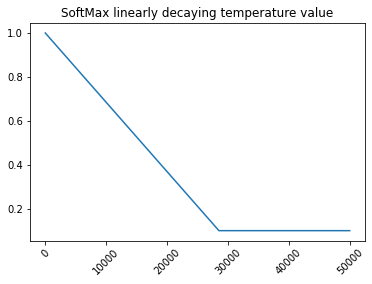

In [14]:
s = SoftMaxStrategy()
plt.plot([s._update_temp() for _ in range(50000)])
plt.title('SoftMax linearly decaying temperature value')
plt.xticks(rotation=45)
plt.show()

## Replay Buffer

In [15]:
class ReplayBuffer():
    def __init__(self,
                 max_size=10000,
                 batch_size=64):
        self.ss_mem = np.empty(shape=max_size, dtype=np.ndarray)
        self.as_mem = np.empty(shape=max_size, dtype=np.ndarray)
        self.rs_mem = np.empty(shape=max_size, dtype=np.ndarray)
        self.ps_mem = np.empty(shape=max_size, dtype=np.ndarray)
        self.ds_mem = np.empty(shape=max_size, dtype=np.ndarray)
        self.max_size = max_size
        self.batch_size = batch_size
        self._idx = 0
        self.size = 0

    def store(self, sample):
        # state, action, reward, next state, done
        s, a, r, p, d = sample
        self.ss_mem[self._idx] = s
        self.as_mem[self._idx] = a
        self.rs_mem[self._idx] = r
        self.ps_mem[self._idx] = p
        self.ds_mem[self._idx] = d
        self._idx += 1
        self._idx = self._idx % self.max_size
        self.size += 1
        self.size = min(self.size, self.max_size)

    def sample(self, batch_size=None):
        if batch_size is None:
            batch_size = self.batch_size
        idxs = np.random.choice(self.size, batch_size, replace=False)
        experiences = np.vstack(self.ss_mem[idxs]), \
                      np.vstack(self.as_mem[idxs]), \
                      np.vstack(self.rs_mem[idxs]), \
                      np.vstack(self.ps_mem[idxs]), \
                      np.vstack(self.ds_mem[idxs])
        return experiences

    def __len__(self):
        return self.size


## Plotting Function

In [16]:
def plot(train_values, eval_values, moving_avg_period):
    plt.figure(2)
    plt.clf()
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(train_values, color="black", label="training")

    training_avg = get_moving_average(moving_avg_period, train_values)
    evaluation_avg = get_moving_average(moving_avg_period, eval_values)
    plt.plot(training_avg, color="blue", label="train avg")
    plt.plot(evaluation_avg, color="red", label="eval avg")
    plt.legend(loc="upper left")
    plt.pause(0.001)
    print(f"Episode {len(train_values)} \n"
      f" {moving_avg_period} episode train avg: {training_avg[-1]} \n"
      f" {moving_avg_period} episode evaluation avg: {evaluation_avg[-1]} \n"
      f" loss: {agent._loss}")
    if is_ipython: display.clear_output(wait=True)

def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1) \
            .mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values)) + 200
        return moving_avg.numpy()


## DQN Agent with the Default Reward
The reward is -1 if the car hasn't reached the goal, 0 if it has reached the goal. The maximum steps in an episode is 200.

In [17]:
class AgentDQN:
    def __init__(self,
                 env,
                 training_strategy,
                 evaluation_strategy,
                 replay_buffer,
                 online_model,
                 target_model,
                 optimizer,
                 lr,
                 gamma,
                 n_warmup_batches,
                 update_target_every_steps,
                 max_episodes,
                 moving_average_period
                 ):
        self.env = env
        self.training_strategy = training_strategy
        self.evaluation_strategy = evaluation_strategy
        self.replay_buffer = replay_buffer
        self.online_model = online_model
        self.target_model = target_model
        for target, online in zip(self.target_model.parameters(), self.online_model.parameters()):
            target.data.copy_(online.data)
        self.optimizer = optimizer
        self.value_optimizer = optimizer(self.online_model.parameters(), lr=lr)
        self.gamma = gamma
        self.n_warmup_batches = n_warmup_batches
        self.update_target_every_steps = update_target_every_steps
        self.max_episodes = max_episodes
        self.moving_average_period = moving_average_period
        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        self.evaluation_scores = []
        self.episode_exploration = []
        self._loss = 0.0

    def interaction_step(self, state, env):
        action = self.training_strategy.select_action(self.online_model, state)
        new_state, reward, is_done, info = env.step(action)
        is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']
        is_failure = is_done and not is_truncated
        experience = (state, action, reward, new_state, float(is_failure))
        self.replay_buffer.store(experience)
        self.episode_reward[-1] += reward
        self.episode_timestep[-1] += 1
        self.episode_exploration[-1] += int(self.training_strategy.exploratory_action_taken)
        return new_state, is_done

    def optimize_model(self, experiences):
        states, actions, rewards, next_states, is_dones = experiences

        max_a_q_sp = self.target_model(next_states).detach().max(1)[0].unsqueeze(1)
        target_q_sa = rewards + (self.gamma * max_a_q_sp * (1 - is_dones))
        q_sa = self.online_model(states).gather(1, actions)

        #td_error = q_sa - target_q_sa
        #value_loss = td_error.pow(2).mul(0.5).mean()
        value_loss = F.mse_loss(q_sa, target_q_sa)
        self._loss = value_loss
        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()

    def evaluate(self, eval_policy_model, eval_env, n_episodes=1):
        rs = []
        step = []
        for _ in range(n_episodes):
            s, d = eval_env.reset(), False
            rs.append(0)
            step.append(0)
            for _ in count():
                a = self.evaluation_strategy.select_action(eval_policy_model, s)
                s, r, d, _ = eval_env.step(a)
                rs[-1] += r
                step[-1] += 1
                if d: break
        return np.mean(step), np.std(step)

In [18]:
agent = AgentDQN(
    env = gym.make("MountainCar-v0"),
    training_strategy = EGreedyExpStrategy(init_epsilon=1.0, min_epsilon=0.1, decay_steps=1000000),
    evaluation_strategy = GreedyStrategy(),
    replay_buffer = ReplayBuffer(max_size=100000, batch_size=64),
    online_model = DQN(2, 3, hidden_dims=(128,128)),
    target_model = DQN(2, 3, hidden_dims=(128,128)),
    optimizer = optim.RMSprop,
    lr = 0.001,
    gamma = 0.99,
    n_warmup_batches = 5,
    update_target_every_steps = 50,
    max_episodes = 300,
    moving_average_period = 50
)

The problem with the default reward is that even with random actions (exploration), the agent struggles to get even one success, so the reward is constantly 0, thus the q-values are not updating correctly.

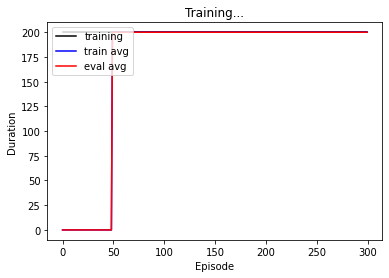

Episode 300 
 50 episode train avg: 200.0 
 50 episode evaluation avg: 200.0 
 loss: 0.06814752519130707


In [19]:
for episode in range(1, agent.max_episodes + 1):
    state, is_done = agent.env.reset(), False
    agent.env.render()
    agent.episode_reward.append(0.0)
    agent.episode_timestep.append(0.0)
    agent.episode_exploration.append(0.0)

    for step in count():
        state, is_done = agent.interaction_step(state, agent.env)
        min_samples = agent.replay_buffer.batch_size * agent.n_warmup_batches
        if len(agent.replay_buffer) > min_samples:
            experiences = agent.replay_buffer.sample()
            experiences = agent.online_model.load(experiences)
            agent.optimize_model(experiences)

        if np.sum(agent.episode_timestep) % agent.update_target_every_steps == 0:
            for target, online in zip(agent.target_model.parameters(), agent.online_model.parameters()):
                target.data.copy_(online.data)

        if is_done:
            evaluation_score, _ = agent.evaluate(agent.online_model, agent.env, n_episodes=5)
            agent.evaluation_scores.append(evaluation_score)
            plot(agent.episode_timestep, agent.evaluation_scores, agent.moving_average_period)
            break
agent.env.close()

In [20]:
agent.training_strategy.epsilon

0.7737229615744537

## DQN Agent with Optimised Reward

The reward is the distance between the next state of the car's position and the current state of the car's position. This encourages the agent to move further. Also give a large reward of 20 when the agent reaches the goal, to prevent agent trying to use the maximum steps to cover as much distance as possible without reaching the goal (so the episode doesn't end)

In [21]:
class AgentDQN:
    def __init__(self,
                 env,
                 training_strategy,
                 evaluation_strategy,
                 replay_buffer,
                 online_model,
                 target_model,
                 optimizer,
                 lr,
                 gamma,
                 n_warmup_batches,
                 update_target_every_steps,
                 max_episodes,
                 moving_average_period
                 ):
        self.env = env
        self.training_strategy = training_strategy
        self.evaluation_strategy = evaluation_strategy
        self.replay_buffer = replay_buffer
        self.online_model = online_model
        self.target_model = target_model
        for target, online in zip(self.target_model.parameters(), self.online_model.parameters()):
            target.data.copy_(online.data)
        self.optimizer = optimizer
        self.value_optimizer = optimizer(self.online_model.parameters(), lr=lr)
        self.gamma = gamma
        self.n_warmup_batches = n_warmup_batches
        self.update_target_every_steps = update_target_every_steps
        self.max_episodes = max_episodes
        self.moving_average_period = moving_average_period
        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        self.evaluation_scores = []
        self.episode_exploration = []
        self._loss = 0.0

    def interaction_step(self, state, env):
        action = self.training_strategy.select_action(self.online_model, state)
        new_state, reward, is_done, info = env.step(action)
        reward = 20 if new_state[0]>=0.5 else abs(new_state[0] - state[0])
        is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']
        is_failure = is_done and not is_truncated
        experience = (state, action, reward, new_state, float(is_failure))
        self.replay_buffer.store(experience)
        self.episode_reward[-1] += reward
        self.episode_timestep[-1] += 1
        self.episode_exploration[-1] += int(self.training_strategy.exploratory_action_taken)
        return new_state, is_done

    def optimize_model(self, experiences):
        states, actions, rewards, next_states, is_dones = experiences

        max_a_q_sp = self.target_model(next_states).detach().max(1)[0].unsqueeze(1)
        target_q_sa = rewards + (self.gamma * max_a_q_sp * (1 - is_dones))
        q_sa = self.online_model(states).gather(1, actions)

        #td_error = q_sa - target_q_sa
        #value_loss = td_error.pow(2).mul(0.5).mean()
        value_loss = F.mse_loss(q_sa, target_q_sa)
        self._loss = value_loss
        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()

    def evaluate(self, eval_policy_model, eval_env, n_episodes=1):
        rs = []
        step = []
        for _ in range(n_episodes):
            s, d = eval_env.reset(), False
            rs.append(0)
            step.append(0)
            for _ in count():
                a = self.evaluation_strategy.select_action(eval_policy_model, s)
                s, r, d, _ = eval_env.step(a)
                rs[-1] += r
                step[-1] += 1
                if d: break
        return np.mean(step), np.std(step)

In [22]:
agent = AgentDQN(
    env = gym.make("MountainCar-v0"),
    training_strategy = EGreedyExpStrategy(init_epsilon=1.0, min_epsilon=0.01, decay_steps=50000),
    evaluation_strategy = GreedyStrategy(),
    replay_buffer = ReplayBuffer(max_size=100000, batch_size=64),
    online_model = DQN(2, 3, hidden_dims=(128,128)),
    target_model = DQN(2, 3, hidden_dims=(128,128)),
    optimizer = optim.RMSprop,
    lr = 0.001,
    gamma = 0.99,
    n_warmup_batches = 5,
    update_target_every_steps = 50,
    max_episodes = 500,
    moving_average_period = 50
)

The duration is the number of steps the agent takes to reach the goal. The aim is to ask the agent to reach the goal with as fewer steps as possible. On average, the agent takes 112 steps to reach the goal.

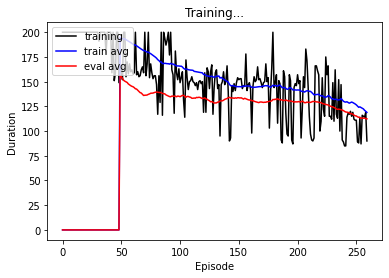

Episode 260 
 50 episode train avg: 118.91999816894531 
 50 episode evaluation avg: 112.43998718261719 
 loss: 0.01685241237282753


In [23]:
for episode in range(1, agent.max_episodes + 1):
    state, is_done = agent.env.reset(), False
    agent.env.render() # can comment this out as doesn't offer too much value, the car moves too quickly for human eye to tell what's going on
    agent.episode_reward.append(0.0)
    agent.episode_timestep.append(0.0)
    agent.episode_exploration.append(0.0)

    for step in count():
        state, is_done = agent.interaction_step(state, agent.env)
        min_samples = agent.replay_buffer.batch_size * agent.n_warmup_batches
        if len(agent.replay_buffer) > min_samples:
            experiences = agent.replay_buffer.sample()
            experiences = agent.online_model.load(experiences)
            agent.optimize_model(experiences)

        if np.sum(agent.episode_timestep) % agent.update_target_every_steps == 0:
            for target, online in zip(agent.target_model.parameters(), agent.online_model.parameters()):
                target.data.copy_(online.data)

        if is_done:
            evaluation_score, _ = agent.evaluate(agent.online_model, agent.env, n_episodes=5)
            agent.evaluation_scores.append(evaluation_score)
            plot(agent.episode_timestep, agent.evaluation_scores, agent.moving_average_period)
            break

    if np.mean(agent.episode_timestep[-agent.moving_average_period:]) < 120:
        agent.env.close() # can comment this out
        gc.collect()
        break

In [24]:
agent.training_strategy.epsilon

0.02547202873577057

## Watching the trained agent to play 5 episodes

In [25]:
for episode in range (5):
    s, d = agent.env.reset(), False
    duration = 0.0
    time.sleep(1)

    for step in count():
        agent.env.render()
        time.sleep(0.05)

        a = agent.evaluation_strategy.select_action(agent.online_model, s)
        s, r, d, _ = agent.env.step(a)
        duration += 1

        if d:
            print(f"Episode {episode+1}: took {duration} steps")
            time.sleep(1)
            agent.env.close()
            break

Episode 1: took 91.0 steps
Episode 2: took 117.0 steps
Episode 3: took 117.0 steps
Episode 4: took 110.0 steps
Episode 5: took 114.0 steps


## Double Deep-Q Network Agent with Optimised Reward

In [26]:
class AgentDDQN:
    def __init__(self,
                 env,
                 training_strategy,
                 evaluation_strategy,
                 replay_buffer,
                 online_model,
                 target_model,
                 optimizer,
                 lr,
                 gamma,
                 n_warmup_batches,
                 update_target_every_steps,
                 max_episodes,
                 moving_average_period
                 ):
        self.env = env
        self.training_strategy = training_strategy
        self.evaluation_strategy = evaluation_strategy
        self.replay_buffer = replay_buffer
        self.online_model = online_model
        self.target_model = target_model
        for target, online in zip(self.target_model.parameters(), self.online_model.parameters()):
            target.data.copy_(online.data)
        self.optimizer = optimizer
        self.value_optimizer = optimizer(self.online_model.parameters(), lr=lr)
        self.gamma = gamma
        self.n_warmup_batches = n_warmup_batches
        self.update_target_every_steps = update_target_every_steps
        self.max_episodes = max_episodes
        self.moving_average_period = moving_average_period
        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        self.evaluation_scores = []
        self.episode_exploration = []
        self._loss = 0.0

    def interaction_step(self, state, env):
        action = self.training_strategy.select_action(self.online_model, state)
        new_state, reward, is_done, info = env.step(action)
        reward = 20 if new_state[0]>=0.5 else abs(new_state[0] - state[0])
        is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']
        is_failure = is_done and not is_truncated
        experience = (state, action, reward, new_state, float(is_failure))
        self.replay_buffer.store(experience)
        self.episode_reward[-1] += reward
        self.episode_timestep[-1] += 1
        self.episode_exploration[-1] += int(self.training_strategy.exploratory_action_taken)
        return new_state, is_done

    def optimize_model(self, experiences):
        states, actions, rewards, next_states, is_dones = experiences
        batch_size = len(is_dones)

        argmax_a_q_sp = self.online_model(next_states).max(1)[1]
        q_sp = self.target_model(next_states).detach()
        max_a_q_sp = q_sp[np.arange(batch_size), argmax_a_q_sp].unsqueeze(1)
        target_q_sa = rewards + (self.gamma * max_a_q_sp * (1 - is_dones))
        q_sa = self.online_model(states).gather(1, actions)

        #td_error = q_sa - target_q_sa
        #value_loss = td_error.pow(2).mul(0.5).mean()
        value_loss = F.mse_loss(q_sa, target_q_sa)
        self._loss = value_loss
        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()

    def evaluate(self, eval_policy_model, eval_env, n_episodes=1):
        rs = []
        step = []
        for _ in range(n_episodes):
            s, d = eval_env.reset(), False
            rs.append(0)
            step.append(0)
            for _ in count():
                a = self.evaluation_strategy.select_action(eval_policy_model, s)
                s, r, d, _ = eval_env.step(a)
                rs[-1] += r
                step[-1] += 1
                if d: break
        return np.mean(step), np.std(step)


In [27]:
agent = AgentDDQN(
    env = gym.make("MountainCar-v0"),
    training_strategy = EGreedyExpStrategy(init_epsilon=1.0, min_epsilon=0.01, decay_steps=50000),
    evaluation_strategy = GreedyStrategy(),
    replay_buffer = ReplayBuffer(max_size=100000, batch_size=64),
    online_model = DQN(2, 3, hidden_dims=(128,128)),
    target_model = DQN(2, 3, hidden_dims=(128,128)),
    optimizer = optim.RMSprop,
    lr = 0.001,
    gamma = 0.99,
    n_warmup_batches = 5,
    update_target_every_steps = 50,
    max_episodes = 500,
    moving_average_period = 50
)


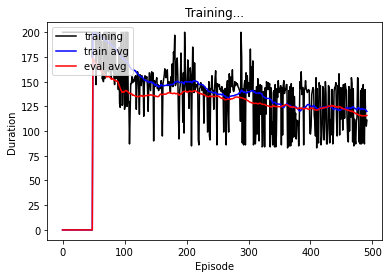

Episode 492 
 50 episode train avg: 119.86000061035156 
 50 episode evaluation avg: 115.86799621582031 
 loss: 0.03894433751702309


In [28]:
for episode in range(1, agent.max_episodes + 1):
    state, is_done = agent.env.reset(), False
    #agent.env.render() # can comment this out as doesn't offer too much value, the car moves too quickly for human eye to tell what's going on
    agent.episode_reward.append(0.0)
    agent.episode_timestep.append(0.0)
    agent.episode_exploration.append(0.0)

    for step in count():
        state, is_done = agent.interaction_step(state, agent.env)
        min_samples = agent.replay_buffer.batch_size * agent.n_warmup_batches
        if len(agent.replay_buffer) > min_samples:
            experiences = agent.replay_buffer.sample()
            experiences = agent.online_model.load(experiences)
            agent.optimize_model(experiences)

        if np.sum(agent.episode_timestep) % agent.update_target_every_steps == 0:
            for target, online in zip(agent.target_model.parameters(), agent.online_model.parameters()):
                target.data.copy_(online.data)

        if is_done:
            evaluation_score, _ = agent.evaluate(agent.online_model, agent.env, n_episodes=5)
            agent.evaluation_scores.append(evaluation_score)
            plot(agent.episode_timestep, agent.evaluation_scores, agent.moving_average_period)
            break

    if np.mean(agent.episode_timestep[-agent.moving_average_period:]) < 120:
        #agent.env.close() # can comment this out
        gc.collect()
        break

## Watching the trained agent to play 5 episodes

In [29]:
for episode in range (5):
    s, d = agent.env.reset(), False
    duration = 0.0
    time.sleep(1)

    for step in count():
        agent.env.render()
        time.sleep(0.05)

        a = agent.evaluation_strategy.select_action(agent.online_model, s)
        s, r, d, _ = agent.env.step(a)
        duration += 1

        if d:
            print(f"Episode {episode+1}: took {duration} steps")
            time.sleep(1)
            agent.env.close()
            break


Episode 1: took 154.0 steps
Episode 2: took 121.0 steps
Episode 3: took 120.0 steps
Episode 4: took 114.0 steps
Episode 5: took 164.0 steps
